In [36]:
# for use with collab:
#from google.colab import drive
#drive.mount('/content/drive')
#!git clone --depth 1 -b rewrite https://github.com/juszjusz/coordinating-quantifiers
#%cd coordinating-quantifiers/v2

In [22]:
import importlib
import plot_utils
import domain_objects
import calculator

importlib.reload(plot_utils)
importlib.reload(domain_objects)
importlib.reload(calculator)

<module 'calculator' from 'D:\\coordinating-quantifiers\\v2\\calculator.py'>

In [23]:
import numpy as np
from domain_objects import GameParams, NewAgent
from new_guessing_game import run_simulation, run_simulations_in_parallel, select_speaker, select_hearer, avg_series, random_functions
from calculator import NumericCalculator, QuotientCalculator, load_stimuli_and_calculator
from ipywidgets import widgets, HBox, VBox
from IPython.display import display, clear_output

style = {'description_width': 'initial'}

stimuli_selection_widget = widgets.Select(options=['numeric', 'quotient'], value='quotient',
                                          description='Stimuli Type:', disabled=False)

ans_selection_widget = widgets.Checkbox(value=True, description='with ANS')

runs_selection_widget = widgets.IntSlider(
    value=2,
    min=1,
    max=10,
    step=1,
    description='Number of runs',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

population_size_selection_widget = widgets.IntSlider(
    value=10,
    min=2,
    max=20,
    step=2,
    description='Population size',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

steps_selection_widget = widgets.IntSlider(
    value=3000,
    min=100,
    max=5000,
    step=100,
    description='Number of steps',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

run_simulation_button = widgets.Button(
    description='Run Simulation',
    disabled=False,
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
    icon='play'
)

simulation_result = {}
output = widgets.Output()


def run_simulation_action(obj):
    run_simulation_button.disabled = True
    run_simulation_button.button_style = 'warning'
    run_simulation_button.icon = 'hourglass'
    run_simulation_button.description = 'Running ...'

    runs_selection_widget.disabled = True
    population_size_selection_widget.disabled = True
    ans_selection_widget.disabled = True
    steps_selection_widget.disabled = True
    stimuli_selection_widget.disabled = True

    runs = runs_selection_widget.value
    population_size = population_size_selection_widget.value
    stimulus = stimuli_selection_widget.value
    steps = steps_selection_widget.value
    with_ans = ans_selection_widget.value

    max_num = 100
    discriminative_threshold = 0.95
    discriminative_history_length = 50
    delta_inc = 0.2
    delta_dec = 0.2
    delta_inh = 0.2
    alpha = 0.01
    super_alpha = 0.001
    beta = 0.2
    guessing_game_2 = False
    seed = 100

    params = GameParams(population_size=population_size,
                        stimulus=stimulus,
                        max_num=max_num,
                        discriminative_threshold=discriminative_threshold,
                        discriminative_history_length=discriminative_threshold,
                        delta_inc=delta_inc,
                        delta_dec=delta_dec,
                        delta_inh=delta_inh,
                        alpha=alpha,
                        super_alpha=super_alpha,
                        beta=beta,
                        steps=steps,
                        runs=runs,
                        guessing_game_2=guessing_game_2,
                        seed=seed)

    with output:
        clear_output()
        print('Running simulation with params:', vars(params))

        stimuli, calculator = load_stimuli_and_calculator(params.stimulus)

        populations = run_simulations_in_parallel(stimuli, calculator, params)

        run_simulation_button.button_style = 'success'
        run_simulation_button.disabled = False
        run_simulation_button.icon = 'play'
        run_simulation_button.description = 'Run Simulation'

        runs_selection_widget.disabled = False
        population_size_selection_widget.disabled = False
        ans_selection_widget.disabled = False
        steps_selection_widget.disabled = False
        stimuli_selection_widget.disabled = False
        
        simulation_result['stimuli'] = stimuli
        simulation_result['params'] = params
        simulation_result['populations'] = populations
        simulation_result['calculator'] = calculator


run_simulation_button.on_click(run_simulation_action)
control_pane = HBox(
    [stimuli_selection_widget, ans_selection_widget, VBox([runs_selection_widget, population_size_selection_widget, steps_selection_widget])])

display(VBox([run_simulation_button, widgets.HTML(value="<hr/>"), control_pane]), output)

Output()

In [72]:
populations = simulation_result['populations']
population = populations[0]
stimuli = simulation_result['stimuli']
calculator = simulation_result['calculator']
params = simulation_result['params']

windowed_communicative_success1 = np.array([[avg_series(a.get_communicative_success1()) for a in population] for population in populations]) * 100
windowed_discriminative_success = np.array([[avg_series(a.get_discriminative_success()) for a in population] for population in populations]) * 100

averaged_windowed_communicative_success1 = np.mean(windowed_communicative_success1, axis=1)
averaged_windowed_discriminative_success= np.mean(windowed_discriminative_success, axis=1)

# Analysis & Visualizations

## Single Agent Analysis

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from plot_utils import bokeh_plot_category, plot_category


In [74]:
agent = population[0]
meanings = agent.compute_word_meanings(stimuli)

word, activations = list(meanings.items())[2]
stimuli_meaning = np.array(stimuli)[activations]
most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in stimuli_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf,
                                        stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

In [75]:
agent = population[0]
word2pragmatic_meaning = agent.compute_word_pragmatic_meanings(stimuli)

word, pragmatic_meaning = list(meanings.items())[0]

most_connected_category = agent.get_most_connected_category(word)
most_connected_category_pdf = most_connected_category.discretized_distribution(calculator)

stimuli_meaning = [float(v) for v in pragmatic_meaning]
figure = plot_utils.bokeh_plot_category(most_connected_category, calculator.domain(), most_connected_category_pdf,
                                        stimuli_meaning)

output_notebook()
show(figure)

Loading BokehJS ...

In [76]:
agent = population[0]
recreated_agent_snapshots = NewAgent.recreate_from_history(agent_id=agent.agent_id, calculator=calculator,
                                                           game_params=params, updates_history=agent.updates_history)

recreating agent 5 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 5524.78it/s]


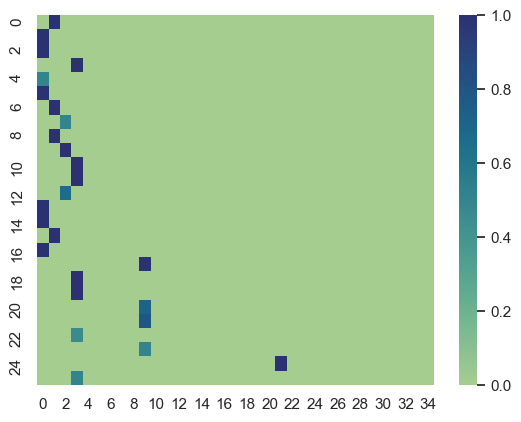

In [77]:
step, snapshot = recreated_agent_snapshots[10]
agent_dict = NewAgent.to_dict(snapshot)
lxc = np.array(agent_dict['lxc'])

sns.set()
ax = sns.heatmap(lxc, vmin=0, vmax=1, cmap="crest")
plt.show()

## Population Statistics

In [78]:
populations_snapshots = [[NewAgent.recreate_from_history(agent_id=a.agent_id, calculator=calculator, game_params=params,
                                                       updates_history=a.updates_history, snapshot_rate=250) for a in
                        population] for population in populations]

recreating agent 2 by updates: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 5539.99it/s]


In [79]:
agent = population[0]
categories = [agent.get_most_responsive_category(s) for s in stimuli]
active_words = [agent.get_most_connected_word(c) for c in categories]
active_words = [w for w in active_words if w is not None]
set(active_words)

{0, 12, 14, 29, 33, 37}

In [80]:
i = 10
ith_population_snapshot = [agent_snapshots[i] for agent_snapshots in population_snapshots]

In [81]:
len(set([w for step, a in ith_population_snapshot for w in a.get_active_words(stimuli)])) / len(population)

2.75

In [82]:
from tqdm import tqdm
populations_active_lexicons = []
for population_snapshots in tqdm(populations_snapshots):
    populations_active_lexicons.append([[snap.get_active_words(stimuli) for step, snap in history[1:]] for history in population_snapshots])
# population_active_lexicon = [[snap.get_words() for step, snap in history[1:]] for history in population_snapshots]
snapshot_steps = [step for step, h in populations_snapshots[0][0]]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:23<00:00, 71.78s/it]


TypeError: cannot unpack non-iterable int object

In [83]:
snapshot_steps = [step for step, h in populations_snapshots[0][0]]

In [85]:
[[len(list(set(word for active_lexicon in snap for word in active_lexicon))) for snap in zip(*population_active_lexicon)]  for population_active_lexicon in populations_active_lexicons]

[[19, 22, 22, 23, 24, 24, 25, 25, 25, 25, 25, 25],
 [20, 19, 20, 22, 21, 21, 23, 23, 24, 24, 24, 24]]

In [106]:
averaged_active_lexicon = np.concatenate(([0], np.mean([[len(list(set(word for active_lexicon in snap for word in active_lexicon))) for snap in zip(*population_active_lexicon)]  for population_active_lexicon in populations_active_lexicons], axis=0)/params.population_size))

In [111]:
from bokeh.plotting import figure

fig = figure(title='Success Rate', x_axis_label='Steps')

steps_range = [*range(params.steps)]
for ds in averaged_windowed_discriminative_success:
    fig.line(steps_range, ds, legend_label='discriminative success', line_width=.1, color='red')
for cs1 in averaged_windowed_communicative_success1:
    fig.line(steps_range, cs1, legend_label='communicative success 1', line_width=.1, color='green')

fig.line(steps_range, np.mean(averaged_windowed_discriminative_success, axis=0), legend_label='discriminative success', line_width=.5, color='red')
fig.line(steps_range, np.mean(averaged_windowed_communicative_success1, axis=0), legend_label='communicative success 1', line_width=.5, color='green')
fig.line(snapshot_steps, averaged_active_lexicon, legend_label='active lexicon', line_width=.5, color='blue')
fig.legend.location = 'bottom_right'

output_notebook()
show(fig)

Loading BokehJS ...